In [4]:
# install Kaggle API to download datasets
!pip install kaggle

# libraries
!pip install tensorflow keras
!pip install matplotlib seaborn pandas scikit-learn


In [1]:
#kaggle.json file
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"coleakers","key":"ca14e6638362301adcd3e13cfc94351e"}'}

In [2]:
#create .kaggle directory
!mkdir -p ~/.kaggle
# move kaggle.json to new dir
!mv kaggle.json ~/.kaggle/
#change permission so readable and writable
!chmod 600 ~/.kaggle/kaggle.json


In [15]:
#list all kaggle sets to makesure histopathologic-cancer is there
!kaggle datasets list


ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datazng/shopping-mall-customer-data-segmentation-analysis  Shopping Mall Customer Data Segmentation Analysis    6MB  2024-08-04 20:36:31            982         29  0.88235295       
myrios/cost-of-living-index-by-country-by-number-2024      Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           1841         22  1.0              
waqi786/cats-dataset                                       🐾 Cats Dataset                                       6KB  2024-07-31 06:12:49           1971         40  1.0              
abhayayare/employee-data-simulation-it-industry            Employee Data Simulation: IT In

In [3]:
#download
!kaggle competitions download -c histopathologic-cancer-detection



100% 6.30G/6.31G [01:15<00:00, 113MB/s]
100% 6.31G/6.31G [01:15<00:00, 89.6MB/s]


In [4]:
#unzip
!unzip histopathologic-cancer-detection.zip
!unzip train.zip -d train
!unzip test.zip -d test


Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffac7f7abed98942f6fabb0a5ef64ddd17f54.tif  
  inflating: train/fa3006

In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

# load the labels
labels = pd.read_csv('train_labels.csv')

# print head to see how it looks
print(labels.head())
print(labels['label'].value_counts())


                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
label
0    130908
1     89117
Name: count, dtype: int64


In [46]:
# so i can use google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# load the labels i realize that i did this above, but because of google collab d/c i ended
# up running these cells alot to finally finish training so this got moved here to run fewer cells
labels = pd.read_csv('train_labels.csv')

# smaller subset of the data
subset_labels = labels.sample(n=5000, random_state=42)  # Adjust the sample size as needed

# function that loads using ID
def load_image(image_id, directory='train'):
    file_path = os.path.join(directory, f'{image_id}.tif')
    return np.array(Image.open(file_path))

# load images for the subset
subset_images = np.array([load_image(img_id) for img_id in subset_labels['id']])
subset_images = subset_images / 255.0  # Normalize
subset_labels = subset_labels['label'].values

# split the subset data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(subset_images, subset_labels, test_size=0.2, random_state=42)




In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Image Data Generator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
# sequential model
#image size
#flatten, prevent overfitting with dropout
# sigmoid for binary classification
model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# build model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.5831 - loss: 0.6816 - val_accuracy: 0.5910 - val_loss: 0.6768
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6019 - loss: 0.6750 - val_accuracy: 0.5910 - val_loss: 0.6804
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5964 - loss: 0.6771 - val_accuracy: 0.5910 - val_loss: 0.6765
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6037 - loss: 0.6719 - val_accuracy: 0.5910 - val_loss: 0.6769
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5931 - loss: 0.6768 - val_accuracy: 0.5910 - val_loss: 0.6769
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5978 - loss: 0.6746 - val_accuracy: 0.5910 - val_loss: 0.6768
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.5935 - loss: 0.6758 - val_accuracy: 0.5910 - val_loss: 0.6765
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.5911 - loss: 0.6779 - val_accu

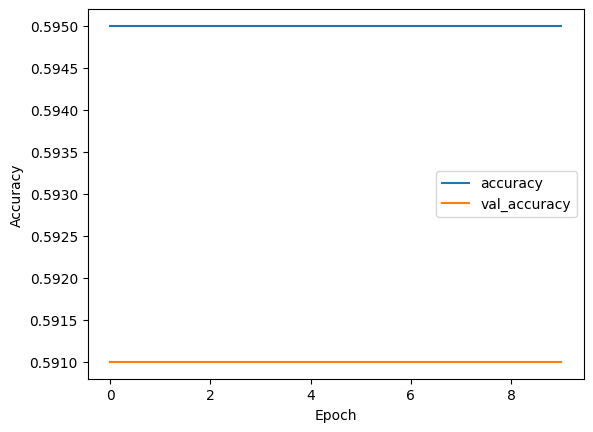

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# END ITERATION 1

In [ ]:
# BEGIN ITERATION 2
# Code altered to improve learning as trial 1 did not seem to improve.

In [ ]:
# data augmentation and preprocessing

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define ImageDataGenerator for data augmentation
# changes from Iteration 1:
# added rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, and horizontal_flip
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'

# validation data generator with rescaling to normalize
val_datagen = ImageDataGenerator(rescale=1./255)

# create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [ ]:
# improve model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

# Define an improved model architecture
# changes from Iteration 1:
#  added BatchNormalization layers
#  added extra Conv2D and MaxPooling2D layer.
#  ept dropout for regularization.
model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,488,513 (9.49 MB)

 Trainable params: 2,487,553 (9.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# define the checkpoint callback
# changes from Iteration 1:
# added ModelCheckpoint
checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True, monitor='val_loss', mode='min')  # Save the model with the best validation loss

# define the learning rate reduction callback
# changes from Iteration 1:
# added ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)  # Reduce learning rate when validation loss plateaus



In [ ]:
# Train the improved model
# changes from Iteration 1:
# added callbacks for checkpointing and learning rate reduction.
history = model.fit(
    train_generator,  # Training data generator
    epochs=20,  # Number of epochs
    validation_data=validation_generator,  # Validation data generator
    callbacks=[checkpoint, reduce_lr]  # Callbacks for checkpointing and learning rate reduction
)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.6870 - loss: 1.4289 - val_accuracy: 0.4090 - val_loss: 1.7066 - learning_rate: 0.0010
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7247 - loss: 0.6931 - val_accuracy: 0.4090 - val_loss: 3.0165 - learning_rate: 0.0010
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.7619 - loss: 0.5262 - val_accuracy: 0.4090 - val_loss: 5.2620 - learning_rate: 0.0010
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7905 - loss: 0.4867 - val_accuracy: 0.4090 - val_loss: 1.9129 - learning_rate: 0.0010
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.8018 - loss: 0.4560 - val_accuracy: 0.5830 - val_loss: 0.6788 - learning_rate: 0.0010
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.8022 - loss: 0.4486 - val_accuracy: 0.5910 - val_loss: 0.9147 - learning_rate: 0.0010
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.8144 - loss: 0.

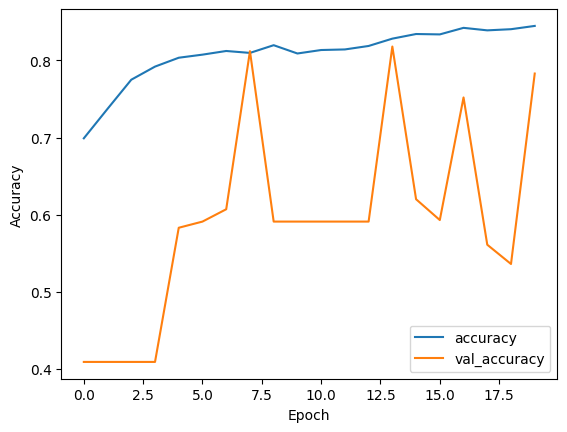

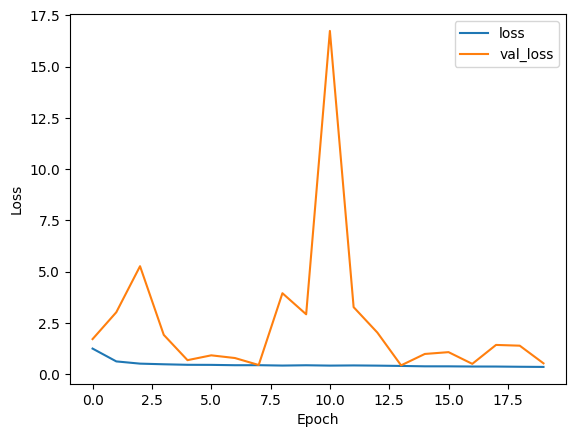

In [ ]:
#Evaluate the iteration 2 model

import matplotlib.pyplot as plt

# plot

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# END ITERATION 2


"""
Key Improvements from Iteration 1 to Iteration 2:

1. Data Augmentation:
   applied various data augmentation techniques such as rotation, width shift, height shift, shear, zoom, and horizontal flip.


2. Batch Normalization:


3. Increased Model Depth:
   added extra Conv2D and MaxPooling2D layer.
   allowed model to learn more complex features and patterns in the data.

4. Regularization Techniques:
   L2 regularization on Conv2D and Dense layers to penalize large weights and prevent overfitting.
   Dropout layers with a rate of 0.5 to further prevent overfitting by randomly dropping units during training, which forces the model to learn more robust features.

5. Learning Rate Reduction:
   callback to reduce the learning rate when the validation loss plateaued.
   allowed the model to converge more effectively, improving validation performance.

6. Model Checkpointing:
   ModelCheckpoint to save the best model based on validation loss.

"""


'\nKey Improvements from Iteration 1 to Iteration 2:\n\n1. Data Augmentation:\n   - Applied various data augmentation techniques such as rotation, width shift, height shift, shear, zoom, and horizontal flip.\n   - This increased the diversity of the training data and helped the model generalize better to unseen data.\n\n2. Batch Normalization:\n   - Added BatchNormalization layers after Conv2D layers.\n   - This helped in stabilizing and accelerating the training process by normalizing the inputs to each layer, reducing the sensitivity to the initialization and improving the convergence rate.\n\n3. Increased Model Depth:\n   - Increased the depth of the model by adding an extra Conv2D and MaxPooling2D layer.\n   - This allowed the model to learn more complex features and patterns in the data, improving its capacity to make accurate predictions.\n\n4. Regularization Techniques:\n   - Incorporated L2 regularization on Conv2D and Dense layers to penalize large weights and prevent overfitt

In [ ]:
#BEGIN ITERATION 3

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# enhanced data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # increased rotation range
    rotation_range=60,
    # increased width shift range
    width_shift_range=0.3,
     # increased height shift range
    height_shift_range=0.3,
    # increased
    shear_range=0.4,
    # increased
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)

# generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2

# Improved Model Architecture
# increased depth and added new regularization techniques
model3 = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    #Dropout for Conv2D layer for regularization

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    #increased Dropout rate
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,488,513 (9.49 MB)

 Trainable params: 2,487,553 (9.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# callbacks
# save the best model
checkpoint = ModelCheckpoint('model_checkpoint3.keras', save_best_only=True, monitor='val_loss', mode='min')

# reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# stop training when a monitored metric has stopped improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
# train the model
history3 = model3.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.6747 - loss: 11.5550 - val_accuracy: 0.4090 - val_loss: 12.4229 - learning_rate: 0.0010
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.7605 - loss: 4.7188 - val_accuracy: 0.4090 - val_loss: 7.3967 - learning_rate: 0.0010
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.7384 - loss: 2.7727 - val_accuracy: 0.4090 - val_loss: 9.3425 - learning_rate: 0.0010
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.7544 - loss: 1.9408 - val_accuracy: 0.5910 - val_loss: 2.2445 - learning_rate: 0.0010
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.7532 - loss: 1.5289 - val_accuracy: 0.4090 - val_loss: 6.6201 - learning_rate: 0.0010
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.7640 - loss: 1.2871 - val_accuracy: 0.5900 - val_loss: 1.8459 - learning_rate: 0.0010
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7777 - loss: 0.9828 - va

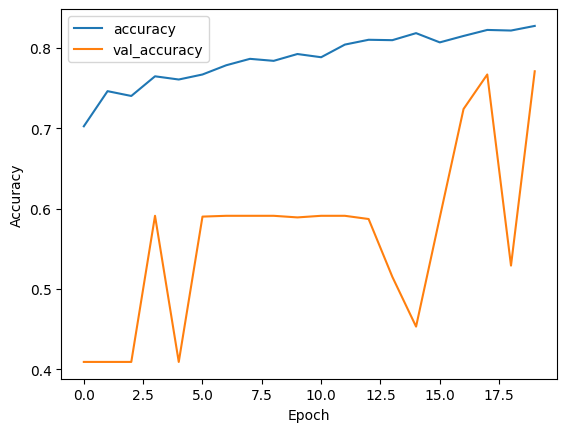

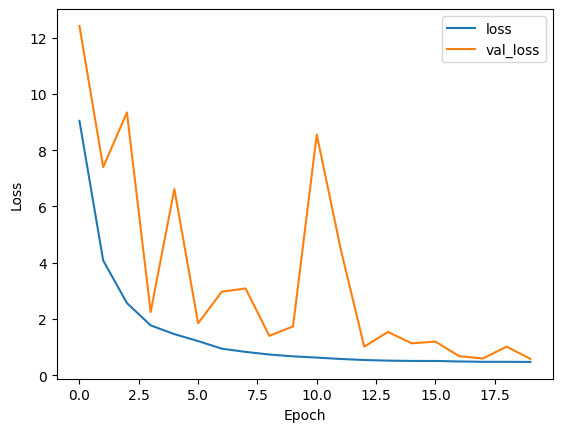

In [ ]:
import matplotlib.pyplot as plt

# plot
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
"""
Key Improvements in Iteration 3:

1. Enhanced Data Augmentation:
   more aggressive data augmentation techniques such as increased rotation, width/height shifts, shear, zoom, and vertical flip.


2. Improved Model Architecture:
   Dropout layers after each Conv2D layer for better regularization, helping to prevent overfitting.
   increased Dropout rate for the Dense layer to 0.5, further reducing the risk of overfitting.


3. Advanced Callbacks:
   ModelCheckpoint: Saved the best model based on validation loss to ensure the best-performing model is retained.
   ReduceLROnPlateau: Adjusted learning rate when validation loss plateaued, allowing the model to converge more effectively.
   EarlyStopping: Stopped training when validation loss stopped improving, preventing overfitting and saving time.
"""

'\nKey Improvements in Iteration 3:\n\n1. Enhanced Data Augmentation:\n   - Applied more aggressive data augmentation techniques such as increased rotation, width/height shifts, shear, zoom, and vertical flip.\n   - This provided a more diverse set of training examples, helping the model generalize better to unseen data.\n\n2. Improved Model Architecture:\n   - Added Dropout layers after each Conv2D layer for better regularization, helping to prevent overfitting.\n   - Increased Dropout rate for the Dense layer to 0.5, further reducing the risk of overfitting.\n   - Maintained BatchNormalization after each Conv2D layer for stabilizing and accelerating training.\n\n3. Advanced Callbacks:\n   - ModelCheckpoint: Saved the best model based on validation loss to ensure the best-performing model is retained.\n   - ReduceLROnPlateau: Adjusted learning rate when validation loss plateaued, allowing the model to converge more effectively.\n   - EarlyStopping: Stopped training when validation los

In [16]:
#END ITERATION 3
#BEGIN ITERATION 4

In [22]:
# import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# load the labels
labels = pd.read_csv('train_labels.csv')

# append .tif extension to the ids
labels['id'] = labels['id'] + '.tif'

# sample a smaller subset of the data 20% of data
labels_subset = labels.sample(frac=0.2, random_state=42)

# convert labels to string
labels_subset['label'] = labels_subset['label'].astype(str)

# load images and preprocess
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    labels_subset,
    directory='train',
    x_col='id',
    y_col='label',
    subset='training',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96))

validation_generator = datagen.flow_from_dataframe(
    labels_subset,
    directory='train',
    x_col='id',
    y_col='label',
    subset='validation',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96))


Found 35204 validated image filenames belonging to 2 classes.
Found 8801 validated image filenames belonging to 2 classes.


In [23]:
# define the model sequential
model4 = Sequential()

# add Input layer
model4.add(tf.keras.Input(shape=(96, 96, 3)))

# add Convolutional layers with BatchNormalization
model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(BatchNormalization())

# flatten the output and add Dense layers with Dropout
model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))  #
model4.add(Dense(1, activation='sigmoid'))


In [24]:
# compile the model
# Adam optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # Lower learning rate
model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
# checkpointing and learning rate reduction
checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Early stopping


In [21]:
# train the  model
history4 = model4.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1363s 1s/step - accuracy: 0.7552 - loss: 1.5932 - val_accuracy: 0.7837 - val_loss: 0.5198 - learning_rate: 0.0010
Epoch 2/15
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1339s 1s/step - accuracy: 0.8232 - loss: 0.4128 - val_accuracy: 0.8310 - val_loss: 0.4108 - learning_rate: 0.0010
Epoch 3/15
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1302s 1s/step - accuracy: 0.8385 - loss: 0.3829 - val_accuracy: 0.6894 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 4/15
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1341s 1s/step - accuracy: 0.8521 - loss: 0.3500 - val_accuracy: 0.6598 - val_loss: 1.2650 - learning_rate: 0.0010
Epoch 5/15
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1360s 1s/step - accuracy: 0.8625 - loss: 0.3247 - val_accuracy: 0.8423 - val_loss: 0.4056 - learning_rate: 0.0010
Epoch 6/15
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1298s 1s/step - accuracy: 0.8807 - loss: 0.2915 - val_accuracy: 0.8849 - val_loss: 0.3058 - learning_rate: 0.0010
Epoch 7/15
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1329s 1s/step - accuracy: 0.8940 

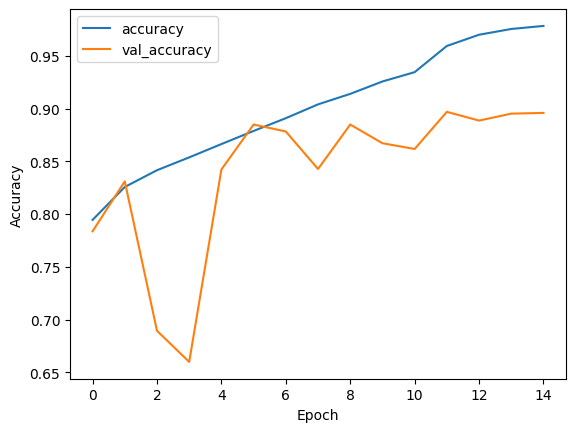

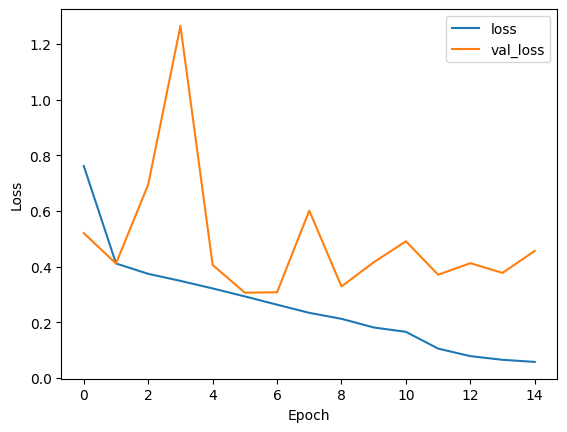

In [22]:
# evaluate the iteration 4 model
import matplotlib.pyplot as plt

# Plot
plt.plot(history4.history['accuracy'], label='accuracy')
plt.plot(history4.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history4.history['loss'], label='loss')
plt.plot(history4.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#Testing

In [35]:
!pip install kaggle

# Ensure the kaggle.json file is correctly placed
from google.colab import files
files.upload()  # Upload the kaggle.json file

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle competitions download -c histopathologic-cancer-detection


Saving kaggle.json to kaggle.json
histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [36]:
!unzip histopathologic-cancer-detection.zip -d histopathologic-cancer-detection
!unzip histopathologic-cancer-detection/train.zip -d histopathologic-cancer-detection/train
!unzip histopathologic-cancer-detection/test.zip -d histopathologic-cancer-detection/test


Archive:  histopathologic-cancer-detection.zip
replace histopathologic-cancer-detection/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: unzip:  cannot find or open histopathologic-cancer-detection/train.zip, histopathologic-cancer-detection/train.zip.zip or histopathologic-cancer-detection/train.zip.ZIP.
unzip:  cannot find or open histopathologic-cancer-detection/test.zip, histopathologic-cancer-detection/test.zip.zip or histopathologic-cancer-detection/test.zip.ZIP.


In [12]:
import os

# list files in the current directory
print("Contents of the current directory:")
print(os.listdir('.'))


Contents of the current directory:
['.config', 'test', 'sample_submission.csv', 'histopathologic-cancer-detection.zip', 'train', 'train_labels.csv', 'histopathologic-cancer-detection', 'drive', 'sample_data']


In [28]:
# google collab deleted the above model4 before i could test it so i ended up submitting a model 4 with fewer epochs to kaggle
#this is training that model with fewer epochs
history4 = model4.fit(
    train_generator,
    epochs=12,
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)


Epoch 1/12
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8262 - loss: 0.4091

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1359s 1s/step - accuracy: 0.8262 - loss: 0.4091 - val_accuracy: 0.8123 - val_loss: 0.4119 - learning_rate: 0.0010
Epoch 2/12
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1320s 1s/step - accuracy: 0.8494 - loss: 0.3682 - val_accuracy: 0.7824 - val_loss: 0.5818 - learning_rate: 0.0010
Epoch 3/12
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1357s 1s/step - accuracy: 0.8560 - loss: 0.3487 - val_accuracy: 0.7176 - val_loss: 0.9273 - learning_rate: 0.0010
Epoch 4/12
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1359s 1s/step - accuracy: 0.8703 - loss: 0.3058 - val_accuracy: 0.6853 - val_loss: 1.1230 - learning_rate: 0.0010
Epoch 5/12
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1371s 1s/step - accuracy: 0.8850 - loss: 0.2803 - val_accuracy: 0.8597 - val_loss: 0.3371 - learning_rate: 0.0010
Epoch 6/12
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1516s 1s/step - accuracy: 0.9013 - loss: 0.2431 - val_accuracy: 0.7707 - val_loss: 1.2477 - learning_rate: 0.0010
Epoch 7/12
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1439s 1s/step - accuracy: 0.9099 

In [29]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
#saved model in my google drive so i wouldn't lose it again
model4.save('/content/drive/My Drive/model4.keras')


In [40]:
model = load_model('/content/drive/My Drive/model4.h5')


In [38]:
#check to make sure train files are still in library
# google collab was removing the testing files and i had to keep downloading and unzipping this was to check if i had to do that


if os.path.exists('train'):
    print("Contents of the 'train' directory:")
    print(os.listdir('train')[:10])
    print("'train' directory does not exist.")



Contents of the 'train' directory:
['1e4587ed3267eed8f6be80ec2b8e05615be3ac06.tif', '81b630fc31be7cdad77179b4dcd8d54e75fc8235.tif', '19187eb1bed99b9b282580ff723f8a7531f3a03f.tif', '9dca596b51a696dd904a4874cbbf0f613869ca87.tif', '568dbbbfeeecb8dc024fb5cf41ea50e0814622a9.tif', '64db9700bad1c63a9d72ddefc514ce59377c2d4a.tif', 'b1b1f5148c25193e088470c6b7a26a6199b7e06f.tif', '58ea010754e9bee6c06728cee7a0da6783e67ac8.tif', '5df2242dc319fe0389e470154124edf262ad1a08.tif', 'ff61eaf3b49aedbd4251d7418ab23a6ea0101454.tif']


In [39]:
# same as above, but for tests
if os.path.exists('test'):
    print("Contents of the 'test' directory:")
    print(os.listdir('test')[:10])
else:
    print("'test' directory does not exist.")


Contents of the 'test' directory:
['4e4321c77a88e49a38c29f3a8fd1870516ec8a7f.tif', 'd1804745f1110d7b3cfa69cd2bdca54bb9d8ff0e.tif', 'ea26bdafec76139317ca8f34ed5ef43c1865b804.tif', '8aab097ee9c9a710b06e5faa3c5d6dae568a049d.tif', '25006e52f32298abf6bc15600867d76a1ca5bf86.tif', '94a69b94996ec936b5177b9f665861f5c9552d5e.tif', '57045149b9d9666235e3804b872085c545345abf.tif', '64273305e3817ab3db540c6fc9150d7804021f3d.tif', 'e83b71814cacb20d8b12cdc470ffaa6ffa0d73b0.tif', '4ef6eec8d8472735f1e3003d9abda6422a853bb2.tif']


In [41]:
# create data generator for the test data

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create a data generator for the test data
test_datagen = ImageDataGenerator(rescale=1./255)

# create a dataframe for the test data
test_filenames = [f"{name}" for name in os.listdir('test')]
test_df = pd.DataFrame(test_filenames, columns=['filename'])
test_df['label'] = 0  # Placeholder labels

# create a test data generator
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory='test',
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)


Found 57458 validated image filenames.


In [42]:
#make predictions
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = (predictions > 0.5).astype(int).flatten()


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 485s 270ms/step


In [43]:
#prepare Kaggle submission

submission_df = pd.DataFrame({
    'id': test_df['filename'].str.replace('.tif', ''),
    'label': predicted_labels
})

# save the  file
submission_df.to_csv('Akers_submission.csv', index=False)


In [45]:
from google.colab import files

# Ddwnload thefile
files.download('Akers_submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
!git config --global user.name "wiak0179"
!git config --global user.email "wiak0179@colorado.edu"


In [48]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:

!ls /content


Akers_submission.csv		      model_checkpoint.keras  train
drive				      sample_data	      train_labels.csv
histopathologic-cancer-detection      sample_submission.csv
histopathologic-cancer-detection.zip  test


In [59]:
# Navigate to the project directory
%cd /content/drive/MyDrive/Akers_Kaggle_HW5

# Initialize Git repository (if not already initialized)
!git init


/content/drive/MyDrive/Akers_Kaggle_HW5
Reinitialized existing Git repository in /content/drive/MyDrive/Akers_Kaggle_HW5/.git/


In [ ]:
"""



"""